## 17.1.1	Extrayendo datos con la api Yfinance

In [2]:
#1. Importar librerías

import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import yfinance as yf

#2. Elegir la empresa

net = yf.Ticker("net") # empresa Cloudflare Inc


# 3. Establezca el período de tiempo que le interesa analizar.

net_historical = net.history(start="2018-01-2", end="2020-12-11", interval="1d")

# 4. Cree un nuevo DataFrame llamado signals, conservando solamente las columnas 'Date' y 'Close' 

signals_df = net_historical.drop(columns=['Open', 'High', 'Low', 'Volume','Dividends', 'Stock Splits'])

## 17.1.2	Establecer las ventanas cortas y largas (medias móviles)

In [3]:
# 5. Establecer los marcos temporales corto y largo

short_window = 50
long_window = 100

# 6. Genere las medias móviles cortas y largas (50 y 100 días, respectivamente)

signals_df['SMA50'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA100'] = signals_df['Close'].rolling(window=long_window).mean()
signals_df['Signal'] = 0.0

# 7. Genere las señales de trading 0 o 1, donde 0 es cuando el SMA50 
# está debajo de SMA100, y    donde 1 es cuando la SMA50 está por encima (o cruza) la SMA100

signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA50'][short_window:] > signals_df['SMA100'][short_window:], 1.0, 0.0)

# 8. Calcule los puntos en el tiempo en los que se debe tomar una posición 1 o -1 

signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# 9. Imprima el DataFrame

signals_df.tail(10)

Close    SMA50   SMA100  Signal  Entry/Exit
Date                                                   
2020-11-27  74.76  54.3126  46.2071     1.0         0.0
2020-11-30  75.08  55.0722  46.5606     1.0         0.0
2020-12-01  72.29  55.7388  46.8827     1.0         0.0
2020-12-02  71.90  56.3794  47.2342     1.0         0.0
2020-12-03  74.13  57.0624  47.6080     1.0         0.0
2020-12-04  77.35  57.8390  48.0203     1.0         0.0
2020-12-07  81.96  58.6774  48.4889     1.0         0.0
2020-12-08  83.55  59.5308  48.9542     1.0         0.0
2020-12-09  77.31  60.2636  49.3436     1.0         0.0
2020-12-10  84.05  61.1234  49.8023     1.0         0.0

## 17.1.3	Generando señales de trading

In [4]:
# 10. Visualice la posición de salida en relación con el precio de cierre.

exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# 11. Visualice la posición de entrada en relación con el precio de cierre

entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# 12.  Visualice el precio de cierre de la inversión

security_close = signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# 13.  Visualice los promedio móviles

moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# 14. Gráficos superpuestos

entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## 17.1.4	Trazando puntos de entrada y salida

In [5]:
# 15. Establecer el capital inicial

initial_capital = float(100000)

# 16. Establecer la cantidad de acciones

share_size = 500

#17. Tome una posición de 500 acciones donde el cruce del promedio móvil dual es 1 (SMA50 es mayor que SMA100)

signals_df['Position'] = share_size * signals_df['Signal']

# 18. Encuentre los puntos en el tiempo en los que se compra o vende una posición de 500 acciones

signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# 19.  Multiplique el precio de la acción por las posiciones de entrada / salida y obtenga la suma acumulativa

signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()

# 20.  Reste del capital inicial las compras realizadas para obtener la cantidad de efectivo líquido 

signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()

#21. Obtenga el valor total del portafolio sumando el monto en efectivo y las inversiones

signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# 22. Calcule la rentabilidad diaria del portafolio

signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# 23. Calcule los rendimientos acumulados

signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# 24. Imprima el DataFrame

signals_df.tail(10)

Close    SMA50   SMA100  Signal  Entry/Exit  Position  \
Date                                                                
2020-11-27  74.76  54.3126  46.2071     1.0         0.0     500.0   
2020-11-30  75.08  55.0722  46.5606     1.0         0.0     500.0   
2020-12-01  72.29  55.7388  46.8827     1.0         0.0     500.0   
2020-12-02  71.90  56.3794  47.2342     1.0         0.0     500.0   
2020-12-03  74.13  57.0624  47.6080     1.0         0.0     500.0   
2020-12-04  77.35  57.8390  48.0203     1.0         0.0     500.0   
2020-12-07  81.96  58.6774  48.4889     1.0         0.0     500.0   
2020-12-08  83.55  59.5308  48.9542     1.0         0.0     500.0   
2020-12-09  77.31  60.2636  49.3436     1.0         0.0     500.0   
2020-12-10  84.05  61.1234  49.8023     1.0         0.0     500.0   

            Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
Date                                                                  
2020-11-27                  0.0             37380.0         91000.0   
2020-11-30                  0.0             37540.0         91000.0   
2020-12-01                  0.0             36145.0         91000.0   
2020-12-02                  0.0             35950.0         91000.0   
2020-12-03                  0.0             37065.0         91000.0   
2020-12-04                  0.0             38675.0         91000.0   
2020-12-07                  0.0             40980.0         91000.0   
2020-12-08                  0.0             41775.0         91000.0   
2020-12-09                  0.0             38655.0         91000.0   
2020-12-10                  0.0             42025.0         91000.0   

            Portfolio Total  Portfolio Daily Returns  \
Date                                                   
2020-11-27         128380.0                 0.018929   
2020-11-30         128540.0                 0.001246   
2020-12-01         127145.0                -0.010853   
2020-12-02         126950.0                -0.001534   
2020-12-03         128065.0                 0.008783   
2020-12-04         129675.0                 0.012572   
2020-12-07         131980.0                 0.017775   
2020-12-08         132775.0                 0.006024   
2020-12-09         129655.0                -0.023498   
2020-12-10         133025.0                 0.025992   

            Portfolio Cumulative Returns  
Date                                      
2020-11-27                       0.28380  
2020-11-30                       0.28540  
2020-12-01                       0.27145  
2020-12-02                       0.26950  
2020-12-03                       0.28065  
2020-12-04                       0.29675  
2020-12-07                       0.31980  
2020-12-08                       0.32775  
2020-12-09                       0.29655  
2020-12-10                       0.33025

In [6]:
# 25. Visualice la posición de salida en relación con el valor total del portafolio

exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)
# 26. Visualice la posición de entrada en relación con el valor total del portafolio

entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400)

# 27. Visualice el valor total del portafolio para la inversión

total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400 )

# 28. Gráficos superpuestos

portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

In [7]:
# 29. Preparar el DataFrame para los indicadores

metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']
columns = ['Backtest']

# 30. Inicialice el DataFrame con el índice establecido en los indicadores de evaluación y la columna como `Backtest` 

portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

## 17.1.5	Realizar Backtest

In [8]:
# 31. Calcular el rendimiento acumulado

portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]

# 32. Calcular la rentabilidad anual

portfolio_evaluation_df.loc['Annual Return'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252)

# 33. Calcular la volatilidad anual

portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))

# 34. Calcular el indicador Sharpe Ratio

portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252) / (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))

# 35. Calcular el rendimiento a la baja

sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0
target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# 36.  Calcular el indicador Sortino Ratio

down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev
portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

Backtest
Annual Return        0.234779
Cumulative Returns    0.33025
Annual Volatility   0.0997506
Sharpe Ratio          2.35366
Sortino Ratio         4.40517

In [9]:
# 37. Iniciar el DataFrame con las columnas para la evaluación de las transacciones

trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

In [11]:
# 38. Inicializar las variables a iterar

entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

for index, row in signals_df.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['Close']
    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['Close'] * row['Entry/Exit Position'])
        exit_share_price = row['Close']
        profit_loss =  entry_portfolio_holding - exit_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': 'NET',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

In [12]:
# 39. Graficar los resultados

price_df = signals_df[['Close', 'SMA50', 'SMA100']]
price_chart = price_df.hvplot.line()
price_chart.opts(title='Cloudflare', xaxis=None)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## 17.1.6 Generar Dashboard o Tablero de Control

In [13]:
# 40. Generar tablero de control

portfolio_evaluation_df.reset_index(inplace=True)
portfolio_evaluation_table = portfolio_evaluation_df.hvplot.table()
portfolio_evaluation_table

:Table   [index,Backtest]

## 17.2	Estrategia de negociación algorítmica con MACD 

## 17.2.4	Implementación del MACD en Python

In [1]:
# 1. Importar librerías

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 2. Almacene los datos en la variable df

df = pd.read_csv('AAPL.csv')

# 3. Establecer la fecha como índice para los datos

df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# 4. Mostrar el DataFrame

df


Date       Open       High      Close  Adj Close     Volume
2017-04-20  4/20/2017  35.305000  35.730000  35.610001  33.930340   93278400
2017-04-21  4/21/2017  35.610001  35.669998  35.567501  33.889851   69283600
2017-04-24  4/24/2017  35.875000  35.987499  35.910000  34.216194   68537200
2017-04-25  4/25/2017  35.977501  36.224998  36.132500  34.428196   75486000
2017-04-26  4/26/2017  36.117500  36.150002  35.919998  34.225719   80164800
...               ...        ...        ...        ...        ...        ...
2017-08-17  8/17/2017  40.130001  40.177502  39.465000  37.906998  111762400
2017-08-18  8/18/2017  39.465000  39.875000  39.375000  37.820560  109712400
2017-08-21  8/21/2017  39.375000  39.472500  39.302502  37.750916  105474000
2017-08-22  8/22/2017  39.557499  40.000000  39.945000  38.368046   86418400
2017-08-23  8/23/2017  39.767502  40.117500  39.994999  38.416069   77596400

[88 rows x 6 columns]

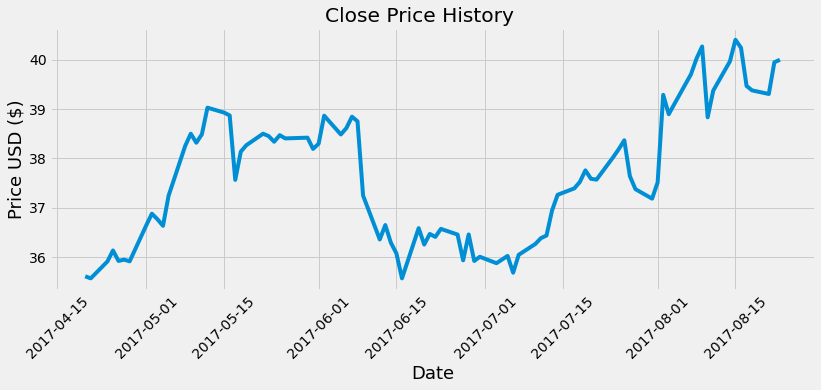

In [2]:
# 5. Mostrar visualmente el precio de las acciones, crear la fígura

title = 'Close Price History    '  # Crear el título

my_stocks = df  #Conseguir las acciones

plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['Close'],  label='Close')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45) 
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.show()


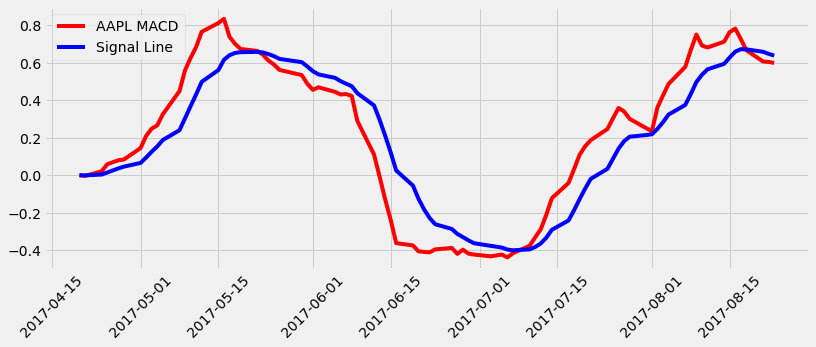

In [4]:
# 6. Calcular la media móvil exponencial a corto plazo

ShortEMA = df.Close.ewm(span=12, adjust=False).mean() #AKA Fast moving average

# 7. Calcular la media móvil exponencial a largo plazo

LongEMA = df.Close.ewm(span=26, adjust=False).mean() #AKA Slow moving average

# 8. Calcular la media móvil Convergence/Divergence (MACD)

MACD = ShortEMA - LongEMA


# 9. Calcular la línea de señal
signal = MACD.ewm(span=9, adjust=False).mean()

# 10.Graficar la figura del MACD

plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, MACD, label='AAPL MACD', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()


In [5]:
# 11. Crea nueva columnas para el DataFrame

df['MACD'] = MACD
df['Signal Line'] = signal

# 12. Mostrar el nuevo DataFrame

df


Date       Open       High      Close  Adj Close     Volume  \
2017-04-20  4/20/2017  35.305000  35.730000  35.610001  33.930340   93278400   
2017-04-21  4/21/2017  35.610001  35.669998  35.567501  33.889851   69283600   
2017-04-24  4/24/2017  35.875000  35.987499  35.910000  34.216194   68537200   
2017-04-25  4/25/2017  35.977501  36.224998  36.132500  34.428196   75486000   
2017-04-26  4/26/2017  36.117500  36.150002  35.919998  34.225719   80164800   
...               ...        ...        ...        ...        ...        ...   
2017-08-17  8/17/2017  40.130001  40.177502  39.465000  37.906998  111762400   
2017-08-18  8/18/2017  39.465000  39.875000  39.375000  37.820560  109712400   
2017-08-21  8/21/2017  39.375000  39.472500  39.302502  37.750916  105474000   
2017-08-22  8/22/2017  39.557499  40.000000  39.945000  38.368046   86418400   
2017-08-23  8/23/2017  39.767502  40.117500  39.994999  38.416069   77596400   

                MACD  Signal Line  
2017-04-20  0.000000     0.000000  
2017-04-21 -0.003390    -0.000678  
2017-04-24  0.021314     0.003720  
2017-04-25  0.058176     0.014611  
2017-04-26  0.069441     0.025577  
...              ...          ...  
2017-08-17  0.725700     0.672078  
2017-08-18  0.666326     0.670928  
2017-08-21  0.606431     0.658028  
2017-08-22  0.603848     0.647192  
2017-08-23  0.598930     0.637540  

[88 rows x 8 columns]

In [6]:
# 13. Cree una función para señalar cuándo comprar y vender un activo

def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    
# si MACD> línea de señal entonces compra sino vende

      if signal['MACD'][i] > signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['Close'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] < signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['Close'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


# 14. Crear columnas de compra y venta

x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

#Mostrar el DataFrame

df


Date       Open       High      Close  Adj Close     Volume  \
2017-04-20  4/20/2017  35.305000  35.730000  35.610001  33.930340   93278400   
2017-04-21  4/21/2017  35.610001  35.669998  35.567501  33.889851   69283600   
2017-04-24  4/24/2017  35.875000  35.987499  35.910000  34.216194   68537200   
2017-04-25  4/25/2017  35.977501  36.224998  36.132500  34.428196   75486000   
2017-04-26  4/26/2017  36.117500  36.150002  35.919998  34.225719   80164800   
...               ...        ...        ...        ...        ...        ...   
2017-08-17  8/17/2017  40.130001  40.177502  39.465000  37.906998  111762400   
2017-08-18  8/18/2017  39.465000  39.875000  39.375000  37.820560  109712400   
2017-08-21  8/21/2017  39.375000  39.472500  39.302502  37.750916  105474000   
2017-08-22  8/22/2017  39.557499  40.000000  39.945000  38.368046   86418400   
2017-08-23  8/23/2017  39.767502  40.117500  39.994999  38.416069   77596400   

                MACD  Signal Line  Buy_Signal_Price  Sell_Signal_Price  
2017-04-20  0.000000     0.000000               NaN                NaN  
2017-04-21 -0.003390    -0.000678               NaN          35.567501  
2017-04-24  0.021314     0.003720             35.91                NaN  
2017-04-25  0.058176     0.014611               NaN                NaN  
2017-04-26  0.069441     0.025577               NaN                NaN  
...              ...          ...               ...                ...  
2017-08-17  0.725700     0.672078               NaN                NaN  
2017-08-18  0.666326     0.670928               NaN          39.375000  
2017-08-21  0.606431     0.658028               NaN                NaN  
2017-08-22  0.603848     0.647192               NaN                NaN  
2017-08-23  0.598930     0.637540               NaN                NaN  

[88 rows x 10 columns]

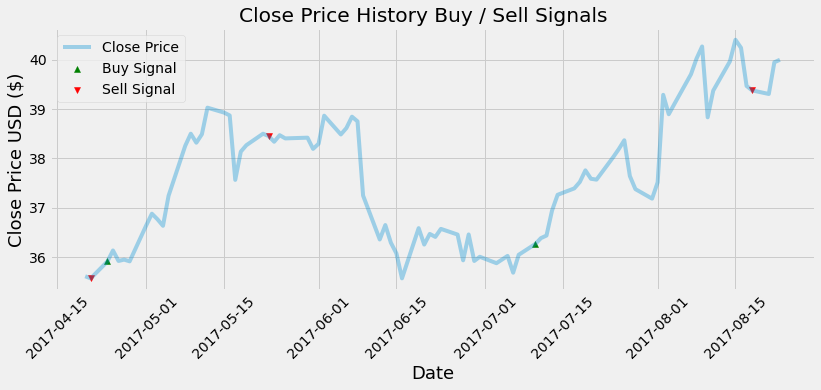

In [7]:
# 15. Mostrar visualmente las señales de compra y venta de acciones, crear fígura

title = 'Close Price History Buy / Sell Signals   '  # Crear el título

my_stocks = df   #Conseguir las acciones

plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['Close'],  label='Close Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend( loc='upper left')
plt.show()
